<a href="https://colab.research.google.com/github/shourya-trikha-12/Cervical-Cancer-Screening/blob/main/Cervical_Cancer_Screening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
%matplotlib inline
import seaborn as sns

In [98]:
input_file_path = '/content/gdrive/My Drive/kag_risk_factors_cervical_cancer.csv'
df = pd.read_csv(input_file_path)  # read the CSV file into df

In [99]:
dfna=df.replace('?', np.nan)    #replace all the '?' characters with NaN

In [100]:
dfna = dfna.apply(pd.to_numeric, errors='coerce')        #turn NaN data into numeric type for computation

In [101]:
dfna = dfna.fillna(dfna.mean())  #replace all the NaN data with mean value for each column

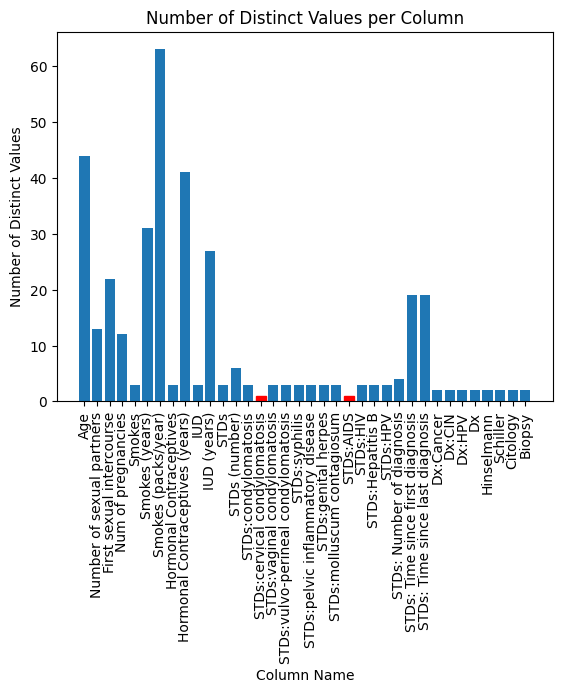

In [102]:
# Create a list of the number of distinct values for each column
num_unique_values = [len(dfna[col].unique()) for col in dfna.columns]

# Create a bar plot of the number of distinct values vs column names
plt.figure()
bars = plt.bar(dfna.columns, num_unique_values)
plt.xticks(rotation=90)
plt.title('Number of Distinct Values per Column')
plt.xlabel('Column Name')
plt.ylabel('Number of Distinct Values')

# Highlight bars with only one distinct value
for i, bar in enumerate(bars):
    if num_unique_values[i] == 1:
        bar.set_color('red')

plt.show()

This shows that STDs:AIDS and STDs:cervical condylomatosis consist of only single data and hence are not suitable features.

In [103]:
dfna.drop(dfna.columns[[14,21]], axis=1, inplace=True) #drop the above two columns specified

In [104]:
df_hinselmann=dfna.drop(dfna.columns[[31,32,33]], axis=1) #drop the other 3 target variables
df_schiller=dfna.drop(dfna.columns[[30,32,33]], axis=1) #drop the other 3 target variables
df_citology=dfna.drop(dfna.columns[[30,31,33]], axis=1) #drop the other 3 target variables
df_biopsy=dfna.drop(dfna.columns[[30,31,32]], axis=1) #drop the other 3 target variables

In [105]:
target_variable = df_hinselmann['Hinselmann']
df_hinselmann = df_hinselmann.drop(['Hinselmann'], axis=1)

# Remove outliers using z-score method
z = (df_hinselmann - df_hinselmann.mean()) / df_hinselmann.std()
df_hinselmann = df_hinselmann[(z.abs() < 3).all(axis=1)]

# Update target variable after removing outliers
target_variable = target_variable.iloc[df_hinselmann.index]
df_hinselmann.loc[:, 'Hinselmann'] = target_variable


target_variable = df_schiller['Schiller']
df_schiller = df_schiller.drop(['Schiller'], axis=1)

# Remove outliers using z-score method
z = (df_schiller - df_schiller.mean()) / df_schiller.std()
df_schiller = df_schiller[(z.abs() < 3).all(axis=1)]

# Update target variable after removing outliers
target_variable = target_variable.iloc[df_schiller.index]
df_schiller.loc[:, 'Schiller'] = target_variable


target_variable = df_citology['Citology']
df_citology = df_citology.drop(['Citology'], axis=1)

# Remove outliers using z-score method
z = (df_citology - df_citology.mean()) / df_citology.std()
df_citology = df_citology[(z.abs() < 3).all(axis=1)]

# Update target variable after removing outliers
target_variable = target_variable.iloc[df_citology.index]
df_citology.loc[:, 'Citology'] = target_variable


target_variable = df_biopsy['Biopsy']
df_biopsy = df_biopsy.drop(['Biopsy'], axis=1)

# Remove outliers using z-score method
z = (df_biopsy - df_biopsy.mean()) / df_biopsy.std()
df_biopsy = df_biopsy[(z.abs() < 3).all(axis=1)]

# Update target variable after removing outliers
target_variable = target_variable.iloc[df_biopsy.index]
df_biopsy.loc[:, 'Biopsy'] = target_variable



In [106]:
#Normalising the dataframes
scaler = MinMaxScaler()
df_norm = scaler.fit_transform(df_hinselmann)
df_h_normalised = pd.DataFrame(df_norm, columns=df_hinselmann.columns)

scaler = MinMaxScaler()
df_norm = scaler.fit_transform(df_schiller)
df_s_normalised = pd.DataFrame(df_norm, columns=df_schiller.columns)

scaler = MinMaxScaler()
df_norm = scaler.fit_transform(df_citology)
df_c_normalised = pd.DataFrame(df_norm, columns=df_citology.columns)

scaler = MinMaxScaler()
df_norm = scaler.fit_transform(df_biopsy)
df_b_normalised = pd.DataFrame(df_norm, columns=df_biopsy.columns)

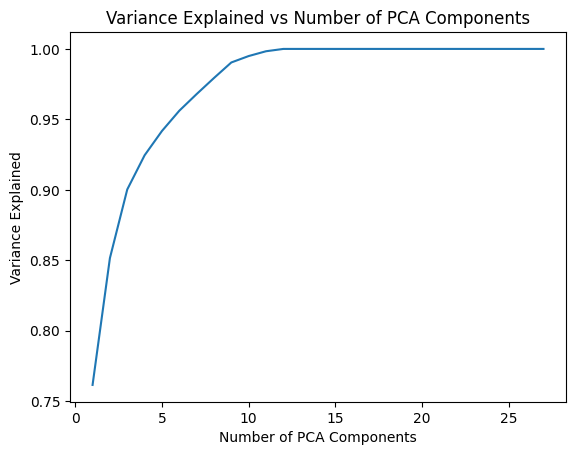

In [107]:
# Apply PCA with varying number of components
num_components = list(range(1, 28))
variance_ratios = []

for n in num_components:
    pca = PCA(n_components=n)
    pca.fit(df_b_normalised)
    variance_ratios.append(np.sum(pca.explained_variance_ratio_))

# plot graph
plt.plot(num_components, variance_ratios)
plt.xlabel('Number of PCA Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained vs Number of PCA Components')
plt.show()

We can see that the explained variance is very close to 1 for number of principle components = 10. So we choose number of PCA components as 10.

In [108]:

X = df_h_normalised.drop('Hinselmann', axis=1)
y = df_h_normalised['Hinselmann']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X_scaled)
df_h_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
df_h_pca['Hinselmann'] = y

X = df_s_normalised.drop('Schiller', axis=1)
y = df_s_normalised['Schiller']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X_scaled)
df_s_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
df_s_pca['Schiller'] = y

X = df_c_normalised.drop('Citology', axis=1)
y = df_c_normalised['Citology']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X_scaled)
df_c_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
df_c_pca['Citology'] = y

X = df_b_normalised.drop('Biopsy', axis=1)
y = df_b_normalised['Biopsy']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X_scaled)
df_b_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
df_b_pca['Biopsy'] = y

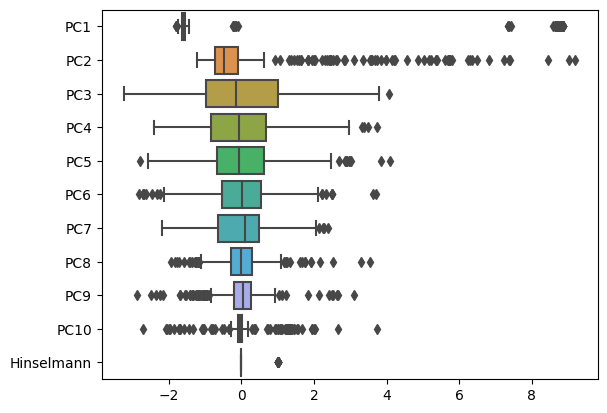

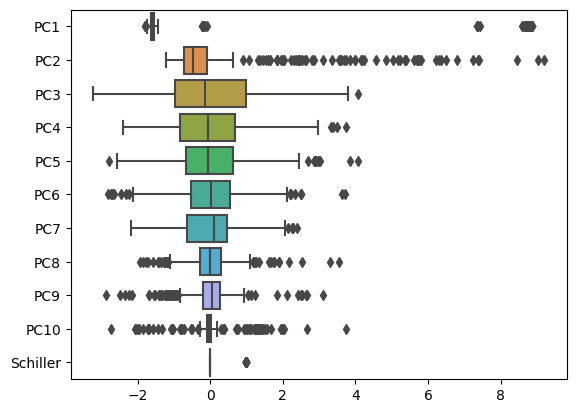

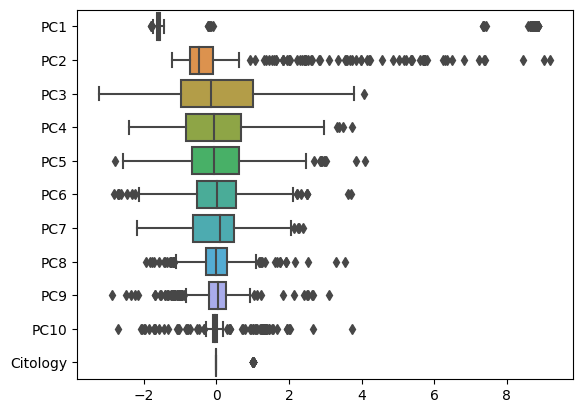

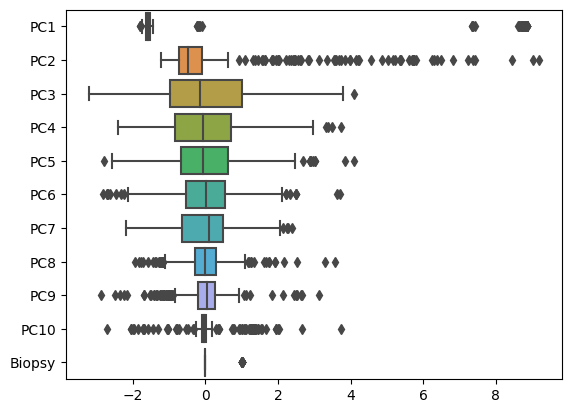

In [109]:
# Visualize the data distribution using boxplot
sns.boxplot(data=df_h_pca, orient='h')
plt.show()
sns.boxplot(data=df_s_pca, orient='h')
plt.show()
sns.boxplot(data=df_c_pca, orient='h')
plt.show()
sns.boxplot(data=df_b_pca, orient='h')
plt.show()

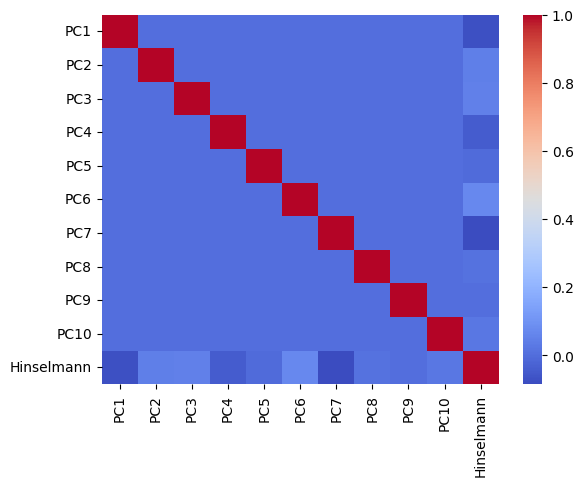

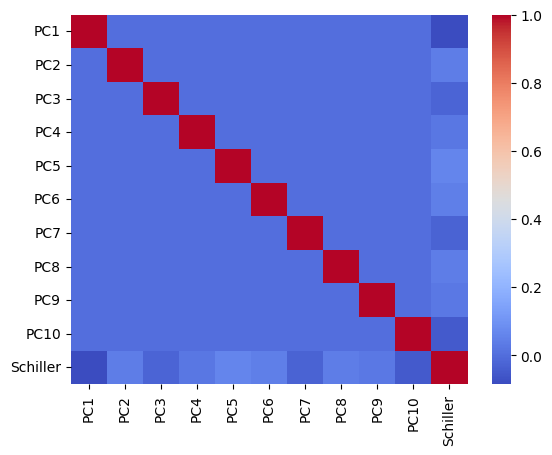

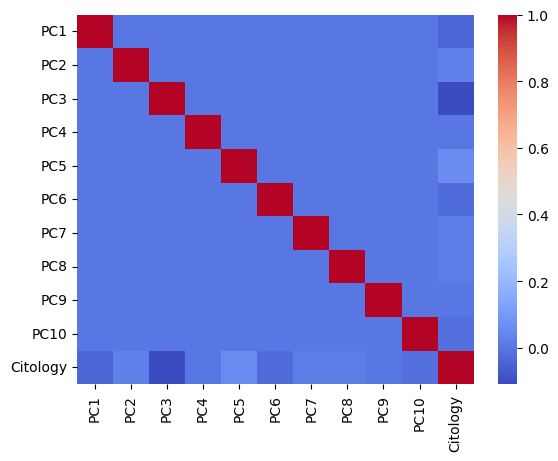

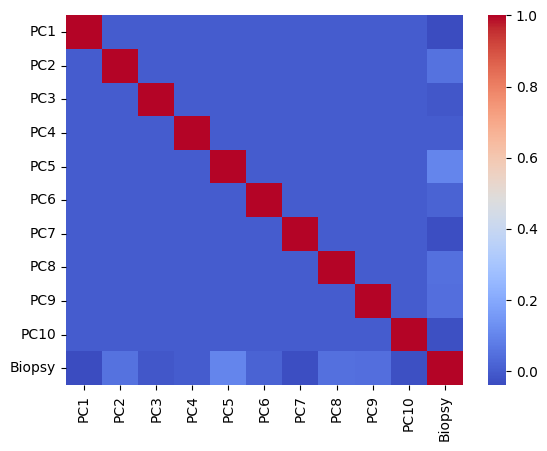

In [110]:
# Compute the correlation matrix and plot the correlation heatmap
corr_matrix = df_h_pca.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

corr_matrix = df_s_pca.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

corr_matrix = df_c_pca.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

corr_matrix = df_b_pca.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

            Accuracy  Precision    Recall
Hinselmann  0.900958   0.043478  0.100000
Schiller    0.862620   0.060606  0.142857
Citology    0.884984   0.083333  0.125000
Biopsy      0.849840   0.023256  0.166667


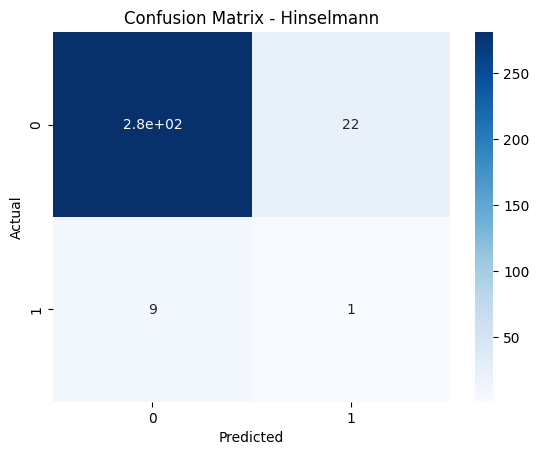

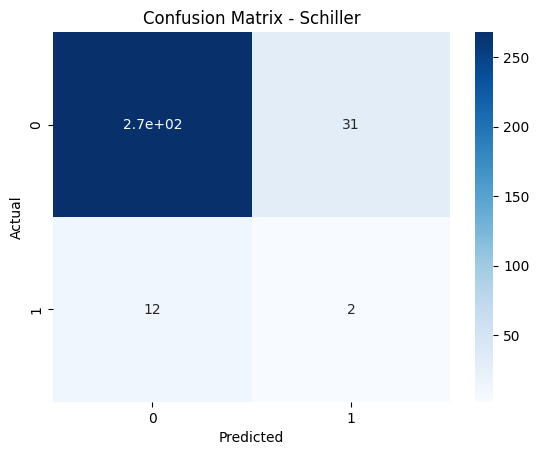

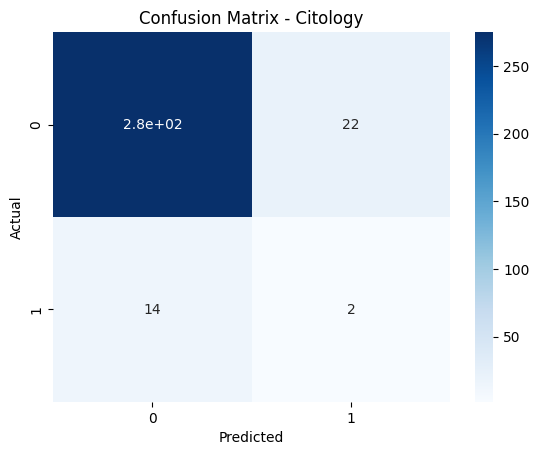

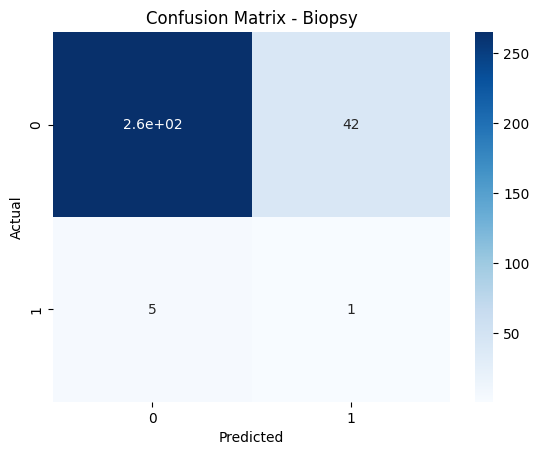

In [111]:
#Training the model using KNN, evaluating the evaluation metrics i.e accuracy, precision and recall and drawing the confusion matrix

#  here we go

X = df_h_pca.drop('Hinselmann', axis=1)
y = df_h_pca['Hinselmann']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=26)

# oversampling the training data
df_train = pd.concat([X_train, y_train], axis=1)
X = df_train.drop('Hinselmann', axis=1)
y = df_train['Hinselmann']
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X, y)

# Train KNN model using GridSearchCV
knn_params = {'n_neighbors': list(range(1, 21)), 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn, knn_params, scoring='accuracy', cv=5)
knn_grid_search.fit(X_train, y_train)
knn_best_params = knn_grid_search.best_params_
knn_best_model = KNeighborsClassifier(**knn_best_params)
knn_best_model.fit(X_train, y_train)

# Make predictions and evaluate model performance on test set
knn_y_pred_test = knn_best_model.predict(X_test)
accuracy_h = accuracy_score(y_test, knn_y_pred_test)
precision_h = precision_score(y_test, knn_y_pred_test)
recall_h = recall_score(y_test, knn_y_pred_test)
conf_mat_h = confusion_matrix(y_test, knn_y_pred_test)

#  here we end

#  here we go

X = df_s_pca.drop('Schiller', axis=1)
y = df_s_pca['Schiller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=26)

# oversampling the training data
df_train = pd.concat([X_train, y_train], axis=1)
X = df_train.drop('Schiller', axis=1)
y = df_train['Schiller']
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X, y)

# Train KNN model using GridSearchCV
knn_params = {'n_neighbors': list(range(1, 21)), 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn, knn_params, scoring='accuracy', cv=5)
knn_grid_search.fit(X_train, y_train)
knn_best_params = knn_grid_search.best_params_
knn_best_model = KNeighborsClassifier(**knn_best_params)
knn_best_model.fit(X_train, y_train)

# Make predictions and evaluate model performance on test set
knn_y_pred_test = knn_best_model.predict(X_test)
accuracy_s = accuracy_score(y_test, knn_y_pred_test)
precision_s = precision_score(y_test, knn_y_pred_test)
recall_s = recall_score(y_test, knn_y_pred_test)
conf_mat_s = confusion_matrix(y_test, knn_y_pred_test)

#  here we end

#  here we go

X = df_c_pca.drop('Citology', axis=1)
y = df_c_pca['Citology']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=26)

# oversampling the training data
df_train = pd.concat([X_train, y_train], axis=1)
X = df_train.drop('Citology', axis=1)
y = df_train['Citology']
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X, y)

# Train KNN model using GridSearchCV
knn_params = {'n_neighbors': list(range(1, 21)), 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn, knn_params, scoring='accuracy', cv=5)
knn_grid_search.fit(X_train, y_train)
knn_best_params = knn_grid_search.best_params_
knn_best_model = KNeighborsClassifier(**knn_best_params)
knn_best_model.fit(X_train, y_train)

# Make predictions and evaluate model performance on test set
knn_y_pred_test = knn_best_model.predict(X_test)
accuracy_c = accuracy_score(y_test, knn_y_pred_test)
precision_c = precision_score(y_test, knn_y_pred_test)
recall_c = recall_score(y_test, knn_y_pred_test)
conf_mat_c = confusion_matrix(y_test, knn_y_pred_test)

#  here we end

#  here we go

X = df_b_pca.drop('Biopsy', axis=1)
y = df_b_pca['Biopsy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=26)

# oversampling the training data
df_train = pd.concat([X_train, y_train], axis=1)
X = df_train.drop('Biopsy', axis=1)
y = df_train['Biopsy']
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X, y)

# Train KNN model using GridSearchCV
knn_params = {'n_neighbors': list(range(1, 21)), 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn, knn_params, scoring='accuracy', cv=5)
knn_grid_search.fit(X_train, y_train)
knn_best_params = knn_grid_search.best_params_
knn_best_model = KNeighborsClassifier(**knn_best_params)
knn_best_model.fit(X_train, y_train)

# Make predictions and evaluate model performance on test set
knn_y_pred_test = knn_best_model.predict(X_test)
accuracy_b = accuracy_score(y_test, knn_y_pred_test)
precision_b = precision_score(y_test, knn_y_pred_test)
recall_b = recall_score(y_test, knn_y_pred_test)
conf_mat_b = confusion_matrix(y_test, knn_y_pred_test)

#  here we end

data = {
    'Accuracy': [accuracy_h, accuracy_s, accuracy_c, accuracy_b],
    'Precision': [precision_h, precision_s, precision_c, precision_b],        # Create a table containing the evaluation metrics
    'Recall': [recall_h, recall_s, recall_c, recall_b]
}
df_table = pd.DataFrame(data, index=['Hinselmann', 'Schiller', 'Citology', 'Biopsy'])
print(df_table)

# Confusion matrix

sns.heatmap(conf_mat_h, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Hinselmann')
plt.show()

sns.heatmap(conf_mat_s, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Schiller')
plt.show()

sns.heatmap(conf_mat_c, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Citology')
plt.show()

sns.heatmap(conf_mat_b, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Biopsy')
plt.show()


            Accuracy  Precision    Recall
Hinselmann  0.926518   0.000000  0.000000
Schiller    0.862620   0.032258  0.071429
Citology    0.881789   0.080000  0.125000
Biopsy      0.897764   0.035714  0.166667


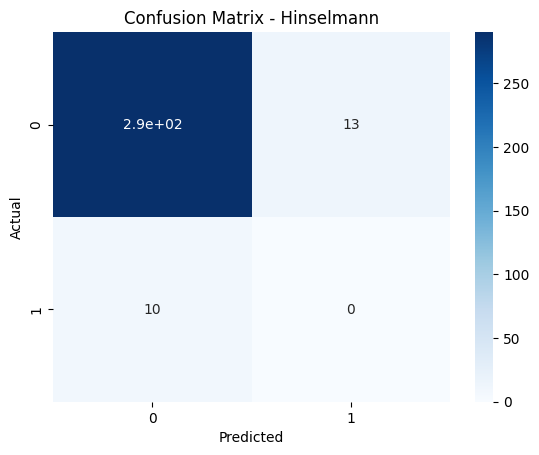

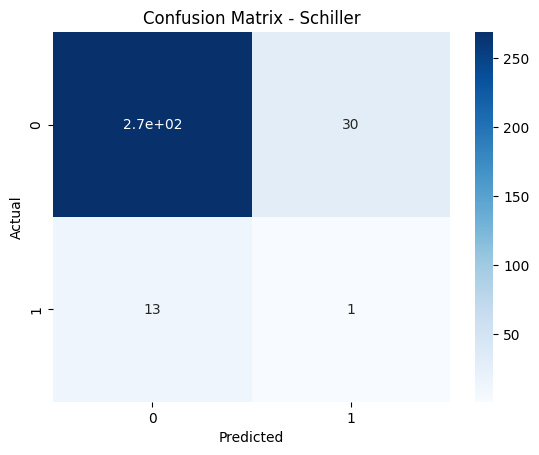

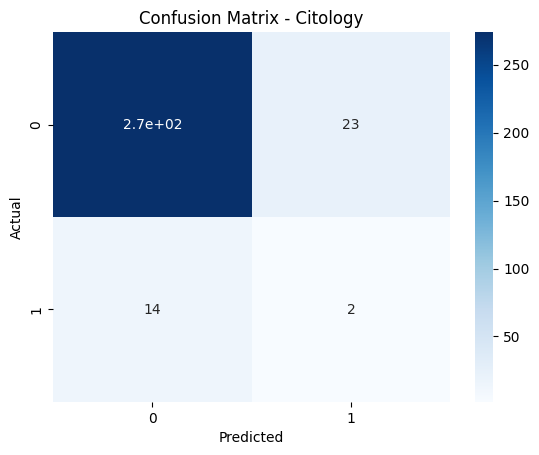

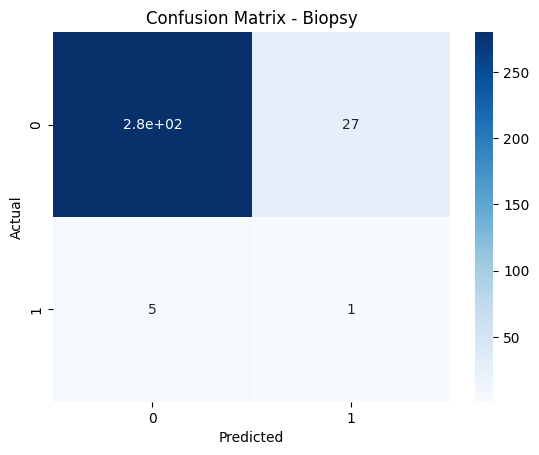

In [112]:
#Training the model using SVM, evaluating the evaluation metrics i.e accuracy, precision and recall and drawing the confusion matrix

#here we go
X = df_h_pca.drop('Hinselmann', axis=1)
y = df_h_pca['Hinselmann']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=26)

# oversampling the training data
df_train = pd.concat([X_train, y_train], axis=1)
X = df_train.drop('Hinselmann', axis=1)
y = df_train['Hinselmann']
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X, y)

# create an SVM classifier
svm = SVC()
# define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
# create a GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, cv=5)
# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)
# create an SVM classifier with the best hyperparameters
svm = SVC(**grid_search.best_params_)
# fit the SVM classifier to the training data
svm.fit(X_train, y_train)
# predict on the test set
y_pred = svm.predict(X_test)
# calculate accuracy, precision, recall, and confusion matrix on the test set
accuracy_h = accuracy_score(y_test, y_pred)
precision_h = precision_score(y_test, y_pred)
recall_h = recall_score(y_test, y_pred)
conf_mat_h = confusion_matrix(y_test, y_pred)
#here we end

# here we go
X = df_s_pca.drop('Schiller', axis=1)
y = df_s_pca['Schiller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=26)

# oversampling the training data
df_train = pd.concat([X_train, y_train], axis=1)
X = df_train.drop('Schiller', axis=1)
y = df_train['Schiller']
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X, y)

# create an SVM classifier
svm = SVC()
# define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
# create a GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, cv=5)
# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)
# create an SVM classifier with the best hyperparameters
svm = SVC(**grid_search.best_params_)
# fit the SVM classifier to the training data
svm.fit(X_train, y_train)
# predict on the test set
y_pred = svm.predict(X_test)
# calculate accuracy, precision, recall, and confusion matrix on the test set
accuracy_s = accuracy_score(y_test, y_pred)
precision_s = precision_score(y_test, y_pred)
recall_s = recall_score(y_test, y_pred)
conf_mat_s = confusion_matrix(y_test, y_pred)
#  here we end

#  here we go
X = df_c_pca.drop('Citology', axis=1)
y = df_c_pca['Citology']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=26)

# oversampling the training data
df_train = pd.concat([X_train, y_train], axis=1)
X = df_train.drop('Citology', axis=1)
y = df_train['Citology']
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X, y)

# create an SVM classifier
svm = SVC()
# define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
# create a GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, cv=5)
# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)
# create an SVM classifier with the best hyperparameters
svm = SVC(**grid_search.best_params_)
# fit the SVM classifier to the training data
svm.fit(X_train, y_train)
# predict on the test set
y_pred = svm.predict(X_test)
# calculate accuracy, precision, recall, and confusion matrix on the test set
accuracy_c = accuracy_score(y_test, y_pred)
precision_c = precision_score(y_test, y_pred)
recall_c = recall_score(y_test, y_pred)
conf_mat_c = confusion_matrix(y_test, y_pred)
#  here we end

#  here we go
X = df_b_pca.drop('Biopsy', axis=1)
y = df_b_pca['Biopsy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=26)

# oversampling the training data
df_train = pd.concat([X_train, y_train], axis=1)
X = df_train.drop('Biopsy', axis=1)
y = df_train['Biopsy']
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X, y)

# create an SVM classifier
svm = SVC()
# define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
# create a GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, cv=5)
# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)
# create an SVM classifier with the best hyperparameters
svm = SVC(**grid_search.best_params_)
# fit the SVM classifier to the training data
svm.fit(X_train, y_train)
# predict on the test set
y_pred = svm.predict(X_test)
# calculate accuracy, precision, recall, and confusion matrix on the test set
accuracy_b = accuracy_score(y_test, y_pred)
precision_b = precision_score(y_test, y_pred)
recall_b = recall_score(y_test, y_pred)
conf_mat_b = confusion_matrix(y_test, y_pred)

# here we end

data = {
    'Accuracy': [accuracy_h, accuracy_s, accuracy_c, accuracy_b],
    'Precision': [precision_h, precision_s, precision_c, precision_b],        # Create a table containing the evaluation metrics
    'Recall': [recall_h, recall_s, recall_c, recall_b]
}
df_table = pd.DataFrame(data, index=['Hinselmann', 'Schiller', 'Citology', 'Biopsy'])
print(df_table)

# Confusion matrix

sns.heatmap(conf_mat_h, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Hinselmann')
plt.show()

sns.heatmap(conf_mat_s, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Schiller')
plt.show()

sns.heatmap(conf_mat_c, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Citology')
plt.show()

sns.heatmap(conf_mat_b, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Biopsy')
plt.show()